<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep10-eda-submission-modeling?scriptVersionId=199429018" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

- Version 1 (09/30/2024)
    * EDA 
    * Baseline modeling 1.0
    
    
- Version 2 (10/01/2024)
    * Baseline modeling 1.0 updated
    

- Version 3 (10/03/2024)
    * Baseline modeling 2.0 added
    
    
- Version 4 (10/03/2024)
    * Hiding Optuna output in baseline modeling 2.0
    
    
# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import gc

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import kurtosis, skew, gmean, mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR

from category_encoders import TargetEncoder

import xgboost as xgb

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e10/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (58645, 12)
The dimension of the test dataset is: (39098, 11)
CPU times: user 170 ms, sys: 48.8 ms, total: 219 ms
Wall time: 284 ms


In [3]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
print('--- Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Test ---\n')
print(100*test.isnull().sum() / train.shape[0])

--- Train ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64


--- Test ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64


There are no missing values neither in the `train` nor `test` data frames. Next, we check for potential duplicates.

In [6]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the loan_status column, there are {sum(train.drop(columns=['loan_status']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the loan_status column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [7]:
temp_train = train.drop(columns=['loan_status'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the distribution of `loan_status`.

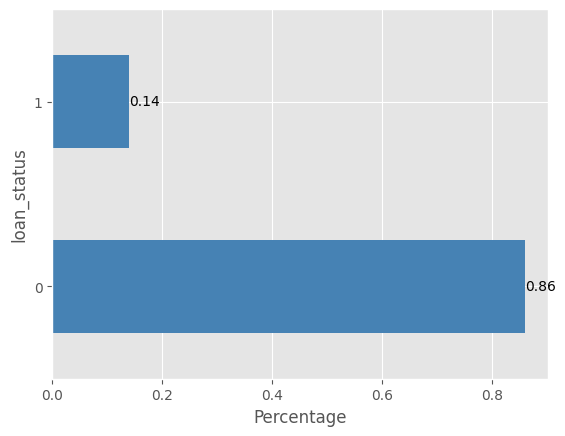

In [8]:
ax = round(train['loan_status'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

From the above chart, we see that this is an imbalanced dataset. `loan_status=1` is the less frequent label. Next, we explore the relationships between the input features and `loan_status`.

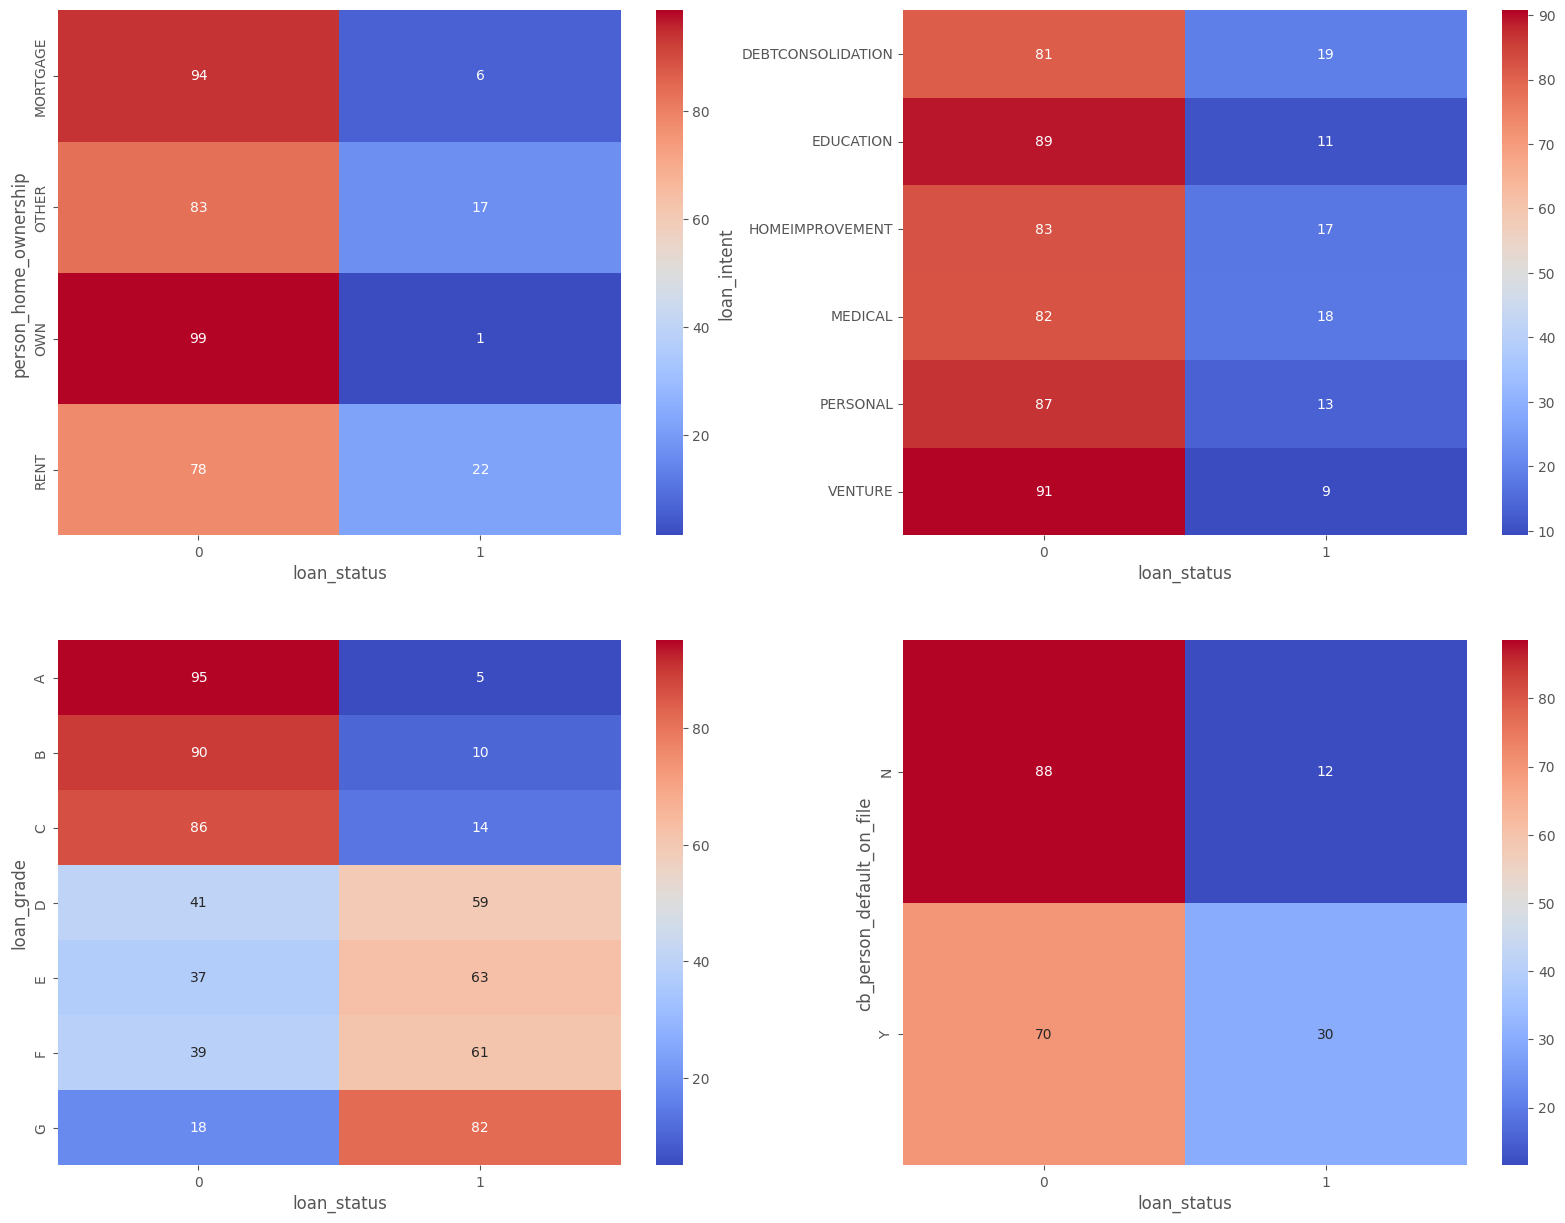

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['person_home_ownership'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 0])
sns.heatmap(data=round(100*pd.crosstab(train['loan_intent'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 1])
sns.heatmap(data=round(100*pd.crosstab(train['loan_grade'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 0]);
sns.heatmap(data=round(100*pd.crosstab(train['cb_person_default_on_file'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 1]);

These are a couple of observations from the above charts:

- When `loan_grade` is equal to `D, E, F,` and `G` have the higher proportions of `loan_status=1`
- `cb_person_default_on_file=Y` have a higher proportion `loan_status=1` when compared to `cb_person_default_on_file=N`

Next, let's explore the distribution of the numerical features and potential relationships with `loan_status`.

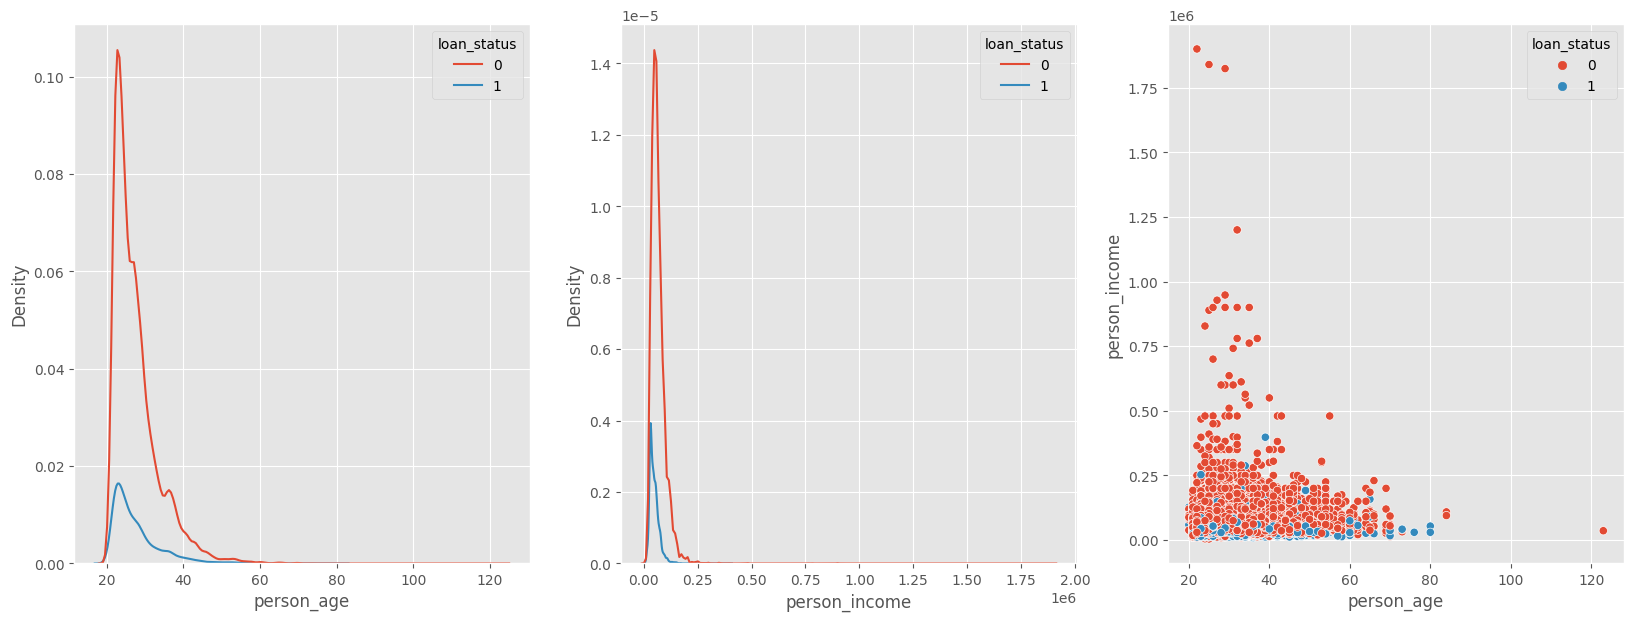

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_age', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='person_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_age', y='person_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_age` and `person_income`.
- There is one person with `person_age=123`.

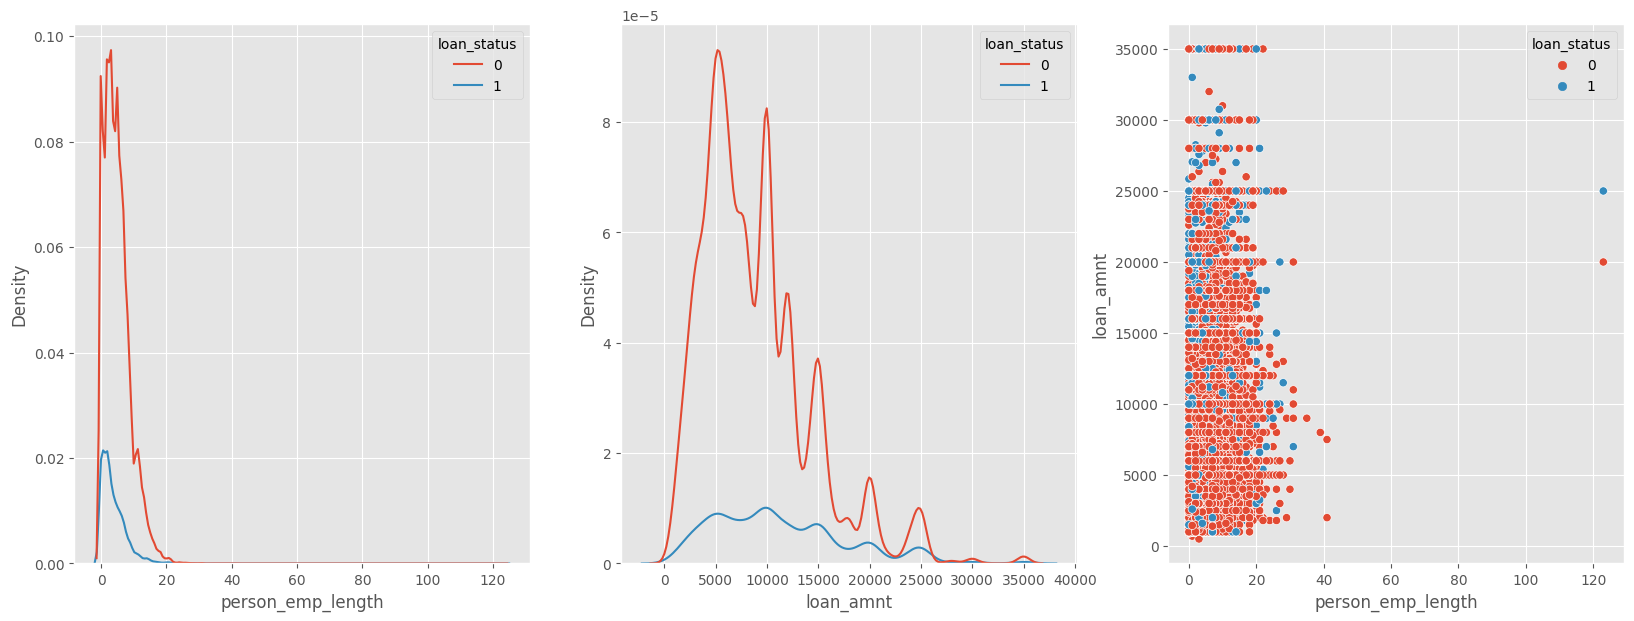

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_emp_length', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_amnt', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_emp_length', y='loan_amnt', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_emp_length` and `loan_amnt`.
- There are two persons with `person_emp_length=123`.

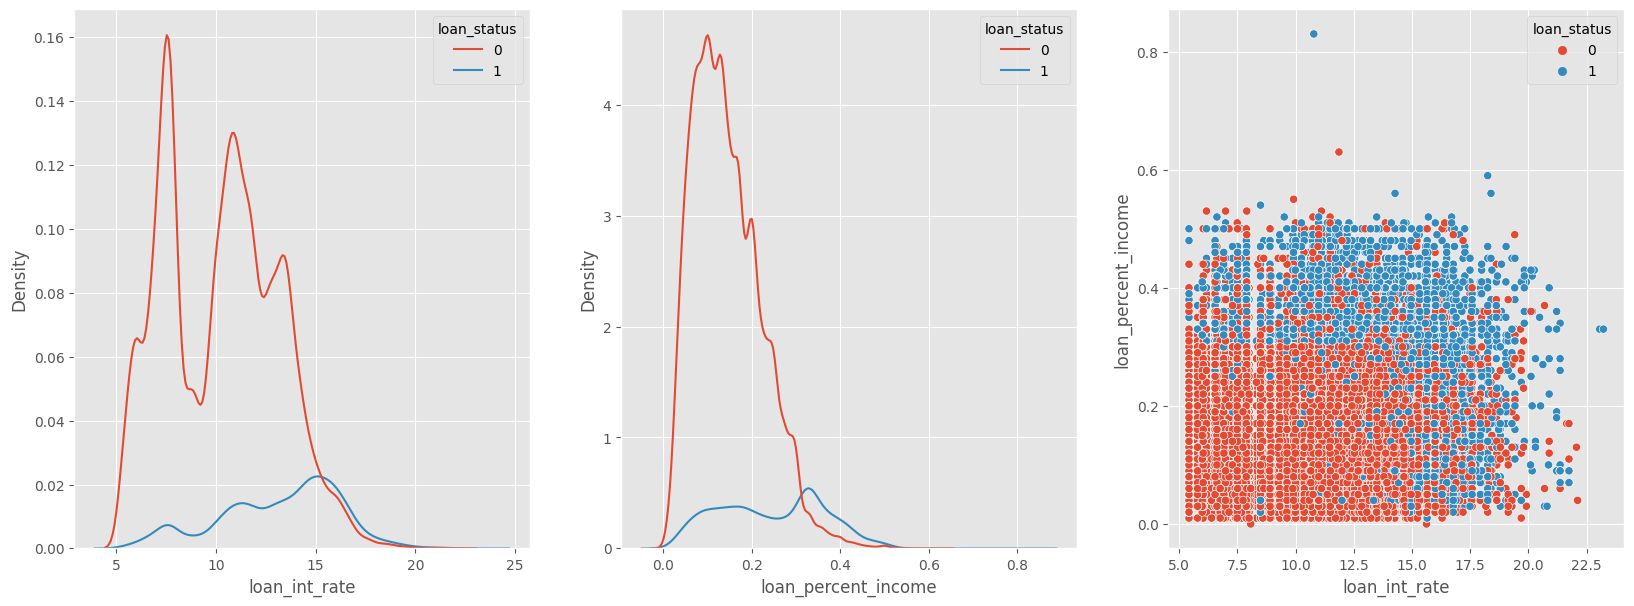

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='loan_int_rate', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_percent_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='loan_int_rate', y='loan_percent_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `loan_int_rate` and `loan_percent_income`.
- There are two loans with `loan_int_rate>23`.
- There are two loans with `loan_percent_income>0.6`.

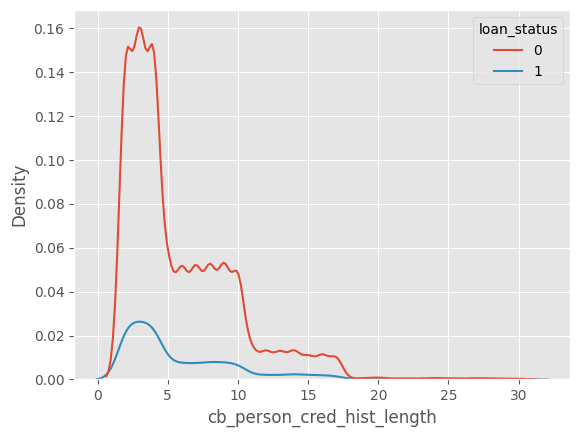

In [13]:
sns.kdeplot(data=train, x='cb_person_cred_hist_length', hue='loan_status');

From the above chart, we see that the distribution of `cb_person_cred_hist_length` is similar whether `loan_statu` is 0 or 1.

# Baseline Modeling 1.0

We first preprocess the data as follows.

In [14]:
%%time
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

def converting_datatypes(df, cat_cols, df_train=False):
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    df['person_age'] = df['person_age'].astype('int32')
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32') 
    
    if df_train==True:

        df['loan_status'] = df['loan_status'].astype('int8')
        
    return df
        
train = converting_datatypes(train, cat_cols ,df_train=True)
test = converting_datatypes(test, cat_cols)


def clip_data(df):
    
    df['person_age'] = df['person_age'].clip(None, 90)
    df['person_emp_length'] = df['person_emp_length'].clip(None, 60) 
    
    return df

train = clip_data(train)
test = clip_data(test)

CPU times: user 51.7 ms, sys: 925 µs, total: 52.6 ms
Wall time: 51 ms


Then, we define the input and target feature for modeling purposes.

In [15]:
%%time
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

CPU times: user 3.97 ms, sys: 893 µs, total: 4.86 ms
Wall time: 4.86 ms


First, we train the `RandomForestClassifier` model as follows.

In [16]:
# Converting label to dummies
train_dummies = pd.get_dummies(X[cat_cols], drop_first=True, dtype='int8')
RF_train = pd.concat([X.drop(columns=cat_cols, axis=1), train_dummies], axis=1)

test_dummies = pd.get_dummies(test[cat_cols], drop_first=True, dtype='int8')
RF_test = pd.concat([test.drop(columns=cat_cols, axis=1), test_dummies], axis=1)

rf_params = {'n_estimators': 148,
             'max_depth': 15,
             'min_samples_split': 17,
             'min_samples_leaf': 6,
             'n_jobs': -1}

scores, rf_oof_preds, rf_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(RF_train, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = RF_train.iloc[train_index], RF_train.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    rf_md = RandomForestClassifier(**rf_params).fit(X_train, y_train)
    preds = rf_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['rf_preds'] = preds
    oof_preds['fold'] = i
    rf_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['rf_preds'] = rf_md.predict_proba(RF_test)[:, 1]
    test_preds['fold'] = i
    rf_test_preds.append(test_preds)

rf_oof_score = np.mean(scores)
rf_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the RandomForest model is {rf_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the RandomForest model is {rf_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9356967178962154
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9444906608254662
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9389035844811371
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9391428673468172
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9347783954952918
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.939954253354496
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9401176172213139
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9359818442256469
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9333163460313417
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9323340195727059
The 10-fold average oof ROC-AUC score of the RandomForest model is 0.937471630645043
The 10-fold std oof ROC-AUC score of

Next, we train the `LightGBM` model as follows.

In [17]:
%%time
lgb_params = {'learning_rate': 0.09030331403653566,
              'n_estimators': 190,
              'max_depth': 15,
              'reg_alpha': 0.25370376964322267,
              'reg_lambda': 0.06912978243728862,
              'num_leaves': 38,
              'colsample_bytree': 0.4816656035216278,
              'verbose': -1,
              'n_jobs': -1}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9615514101022608
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9621418792633423
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9604949941072128
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9578878822871156
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9598626206830871
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9618800180509929
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9586113118761483
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9603635441386068
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9543917136893444
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9596434095420214
The 10-fold average oof ROC-AUC score of the LGBM model is 0.9596828783740132
The 10-fold std oof ROC-AUC score of the L

After that, we train the `XGBoost` model as follows.

In [18]:
%%time
xgb_params = {'n_estimators': 199,
              'max_depth': 12,
              'learning_rate': 0.09304789779291263,
              'gamma': 0.2571967403496238,
              'min_child_weight': 20,
              'colsample_bytree': 0.5141737333809174,
              'n_jobs': -1,
              'enable_categorical': True}

scores, xgb_oof_preds, xgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
                        
    xgb_md = XGBClassifier(**xgb_params).fit(X_train, y_train)
    preds = xgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['xgb_preds'] = preds
    oof_preds['fold'] = i
    xgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['xgb_preds'] = xgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    xgb_test_preds.append(test_preds)

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the XGBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9584907322531875
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9599021440220951
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9557338603111868
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9544329234175783
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9564890894156022
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9584948615395973
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9561903832025748
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9570726909672401
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9558919940988971
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9572874930195285
The 10-fold average oof ROC-AUC score of the XGBoost model is 0.9569986172247488
The 10-fold std oof ROC-AUC score of th

Next, we train the `CatBoost` model as follows.

In [19]:
cb_params = {'loss_function': 'Logloss',
             'iterations': 195,
             'learning_rate': 0.09381481508561976,
             'depth': 11,
             'bagging_temperature': 0.0850640366226123,
             'l2_leaf_reg': 0,
             'grow_policy': 'Lossguide',
             'task_type': 'CPU'}

test_pool = Pool(data=test, cat_features=cat_cols)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostClassifier(**cb_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict_proba(eval_pool)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict_proba(test_pool)[:, 1]
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof RMSE score is 0.9571600338091213
------------ Working on Fold 1 ------------
The oof RMSE score is 0.9583169247985143
------------ Working on Fold 2 ------------
The oof RMSE score is 0.9621294984583517
------------ Working on Fold 3 ------------
The oof RMSE score is 0.9557538600730943
------------ Working on Fold 4 ------------
The oof RMSE score is 0.9523503291627481
------------ Working on Fold 5 ------------
The oof RMSE score is 0.9593474018358192
------------ Working on Fold 6 ------------
The oof RMSE score is 0.9563201693649885
------------ Working on Fold 7 ------------
The oof RMSE score is 0.9564428113349757
------------ Working on Fold 8 ------------
The oof RMSE score is 0.9550111151727168
------------ Working on Fold 9 ------------
The oof RMSE score is 0.9550008751635721
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9567833019173901
The 10-fold std oof ROC-AUC score of the CatBoost model is 0.0015265

Finally, we run an Optuna experiment to blend the out-of-fold predictions of `RandomForest`, `LightGBM`, `XGBoost`, and `CatBoost`.

In [20]:
%%time
oof_preds = pd.concat(lgb_oof_preds)
oof_preds['xgb_preds'] = pd.concat(xgb_oof_preds)['xgb_preds']
oof_preds['cat_preds'] = pd.concat(cat_oof_preds)['cat_preds']
oof_preds['rf_preds'] = pd.concat(rf_oof_preds)['rf_preds']


def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-5, 1) for n in range(4)]

    scores = list()
    for i in range(0, 10):
        
        x_test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
        ens_pred = (weights[0]*x_test['lgb_preds'].values +
                    weights[1]*x_test['xgb_preds'].values + 
                    weights[2]*x_test['cat_preds'].values + 
                    weights[3]*x_test['rf_preds'].values) 
        
        y_test = x_test['y']
        score = roc_auc_score(y_test, ens_pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3000, n_jobs=-1)

[I 2024-10-04 04:13:57,428] A new study created in memory with name: no-name-0fccf822-d48e-40f3-a1d8-bf887b840aa0
[I 2024-10-04 04:13:57,692] Trial 0 finished with value: 0.9569800860039093 and parameters: {'weight0': 0.7921329865336716, 'weight1': 0.61247125080395, 'weight2': 0.7224512959639303, 'weight3': 0.9579678851028174}. Best is trial 0 with value: 0.9569800860039093.
[I 2024-10-04 04:13:57,701] Trial 1 finished with value: 0.9570267725533828 and parameters: {'weight0': 0.030971430752002663, 'weight1': 0.7456120471385947, 'weight2': 0.7638461315706074, 'weight3': 0.45653012725190445}. Best is trial 1 with value: 0.9570267725533828.
[I 2024-10-04 04:13:57,716] Trial 2 finished with value: 0.9572709915352469 and parameters: {'weight0': 0.8231241549309177, 'weight1': 0.5213336622594338, 'weight2': 0.8478752347203785, 'weight3': 0.8844250771109852}. Best is trial 2 with value: 0.9572709915352469.
[I 2024-10-04 04:13:57,775] Trial 3 finished with value: 0.9555492050654957 and paramet

CPU times: user 7min 44s, sys: 2.95 s, total: 7min 47s
Wall time: 7min 46s


In [21]:
%%time
print("Best Trial:")
best_trial = study.best_trial

print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.9604003108561692
  Params: 
    weight0: 0.7100977018510305
    weight1: 0.22290672423806884
    weight2: 0.3131655811316197
    weight3: 5.6463040582355244e-05
CPU times: user 544 µs, sys: 0 ns, total: 544 µs
Wall time: 521 µs


In [22]:
%%time
w = study.best_trial.params
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    optuna_pred = (w['weight0']*test['lgb_preds'] + w['weight1']*test['xgb_preds'] + w['weight2']*test['cat_preds'] + w['weight3']*test['rf_preds'])
    score = roc_auc_score(y_test, optuna_pred)
    scores.append(score)

print(f"The 10-fold oof average ROC-AUC score of the Optuna Blender is {np.mean(scores)}")


The 10-fold oof average ROC-AUC score of the Optuna Blender is 0.9604003108561692
CPU times: user 115 ms, sys: 5 µs, total: 115 ms
Wall time: 114 ms


The following table summarizes the results so far.

In [23]:
results = pd.DataFrame()
results['Model'] = ['RF', 'LGBM', 'XGB', 'CatBoost', 'Optuna Blend']
results['10-fold oof ROC-AUC'] = [rf_oof_score, lgb_oof_score, xgb_oof_score, cat_oof_score, np.mean(scores)] 
print(results)

          Model  10-fold oof ROC-AUC
0            RF             0.937472
1          LGBM             0.959683
2           XGB             0.956999
3      CatBoost             0.956783
4  Optuna Blend             0.960400


From the above, we see that the `Optuna Blend` has the better out-of-fold `ROC-AUC` score. Thus, we use the `Optuna Blend` strategy to blend the predictions on the `test` data set.

In [24]:
%%time
test_preds = pd.concat(lgb_test_preds)
test_preds['xgb_preds'] = pd.concat(xgb_test_preds)['xgb_preds']
test_preds['cat_preds'] = pd.concat(cat_test_preds)['cat_preds']
test_preds['rf_preds'] = pd.concat(rf_test_preds)['rf_preds']
test_preds.head()

CPU times: user 22.4 ms, sys: 10 ms, total: 32.5 ms
Wall time: 32 ms


,lgb_preds,fold,xgb_preds,cat_preds,rf_preds
0,0.987975,0,0.987820,0.990004,0.836745
1,0.012344,0,0.016124,0.016007,0.031932
2,0.534855,0,0.765667,0.626705,0.670374
3,0.010490,0,0.012575,0.013469,0.032573
4,0.053700,0,0.052235,0.048456,0.288301


In [25]:
%%time
test_pred_final = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']

    temp = test_preds[test_preds['fold']==i].reset_index(drop=True)
    optuna_pred = (w['weight0']*temp['lgb_preds'] + w['weight1']*temp['xgb_preds'] + w['weight2']*temp['cat_preds'] + w['weight3']*temp['rf_preds'])
    
    test_pred_final.append(optuna_pred)

CPU times: user 89.8 ms, sys: 0 ns, total: 89.8 ms
Wall time: 89.3 ms


In [26]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 12.9 ms, sys: 7.01 ms, total: 19.9 ms
Wall time: 31.3 ms


,id,loan_status
0,58645,1.232058
1,58646,0.019925
2,58647,0.768214
3,58648,0.013950
4,58649,0.066925


In [27]:
%%time
submission.to_csv('baseline_sub_1.csv', index=False)

del train, test, submission, X, Y, test_pred_final, scores, w, oof_preds, test_preds
gc.collect()

CPU times: user 335 ms, sys: 3.94 ms, total: 339 ms
Wall time: 339 ms


23120

# Baseline 2.0 

In this section, we re-train the models by combining the competition and the original datasets for training purposes.

In [28]:
%%time
train = pd.read_csv('../input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e10/test.csv', index_col=0)
original = pd.read_csv('../input/loan-approval-prediction/credit_risk_dataset.csv')

cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

def converting_datatypes(df, cat_cols, df_train=False):
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    df['person_age'] = df['person_age'].astype('int32')
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32') 
    
    if df_train==True:

        df['loan_status'] = df['loan_status'].astype('int8')
        
    return df
        
train = converting_datatypes(train, cat_cols ,df_train=True)
test = converting_datatypes(test, cat_cols)
original = converting_datatypes(original, cat_cols)

def clip_data(df):
    
    df['person_age'] = df['person_age'].clip(None, 90)
    df['person_emp_length'] = df['person_emp_length'].clip(None, 60) 
    
    return df

train = clip_data(train)
test = clip_data(test)
original = clip_data(original)

CPU times: user 297 ms, sys: 16 ms, total: 313 ms
Wall time: 332 ms


In [29]:
%%time
X = train.drop('loan_status', axis=1)
X['generated'] = 1
Y = train['loan_status']

X_org = original.drop('loan_status', axis=1)
X_org['generated'] = 0
y_org = original['loan_status']

test['generated'] = 1

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

CPU times: user 7.14 ms, sys: 1.01 ms, total: 8.15 ms
Wall time: 7.48 ms


First, we train the `LGBMClassifier` model.

In [30]:
%%time
lgb_params = {'learning_rate': 0.09967204378010042,
              'n_estimators': 293,
              'max_depth': 11,
              'reg_alpha': 1.8071679385784074,
              'reg_lambda': 0.013057189102691127,
              'num_leaves': 35,
              'colsample_bytree': 0.4708077087365519,
              'verbose': -1,
              'n_jobs': -1}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
    
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9638856680277615
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9641099510720111
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9656387423959238
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9593485791835812
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9647554195783384
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9644300184677373
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9609979484260748
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9655080771048875
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9599027437271015
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9633239784102506
The 10-fold average oof ROC-AUC score of the LGBM model is 0.9631901126393668
The 10-fold std oof ROC-AUC score of the L

Next, we train the `LGBMClassifier` with `dart` booster.

In [31]:
%%time
lgb_dart_params = {'boosting_type': 'dart',
                   'learning_rate': 0.09755475070802529,
                   'n_estimators': 289,
                   'max_depth': 12,
                   'reg_alpha': 0.396286496452296,
                   'reg_lambda': 0.01930416713070059,
                   'num_leaves': 40,
                   'colsample_bytree': 0.5305154955728938,
                   'verbose': -1,
                   'n_jobs': -1}

scores, lgb_dart_oof_preds, lgb_dart_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
    
    lgb_md = LGBMClassifier(**lgb_dart_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_dart_preds'] = preds
    oof_preds['fold'] = i
    lgb_dart_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_dart_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_dart_test_preds.append(test_preds)

lgb_dart_oof_score = np.mean(scores)
lgb_dart_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM (dart) model is {lgb_dart_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM (dart) model is {lgb_dart_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9614359352864846
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9616566469446791
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9627113962929011
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9569488458470733
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9590528684182331
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.961950031136772
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9602625728856465
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9601849393279458
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9554581034788645
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9599215567671577
The 10-fold average oof ROC-AUC score of the LGBM (dart) model is 0.9599582896385759
The 10-fold std oof ROC-AUC score of

Next, we train the `LGBMClassifier` with `goss` booster.

In [32]:
%%time
lgb_goss_params = {'boosting_type': 'goss',
                   'learning_rate': 0.09833586641055655,
                   'n_estimators': 293,
                   'max_depth': 12,
                   'reg_alpha': 0.10125985871865179,
                   'reg_lambda': 0.1312779378943349,
                   'num_leaves': 40,
                   'colsample_bytree': 0.5037005285619212,
                   'verbose': -1,
                   'n_jobs': -1}

scores, lgb_goss_oof_preds, lgb_goss_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
    
    lgb_md = LGBMClassifier(**lgb_goss_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_goss_preds'] = preds
    oof_preds['fold'] = i
    lgb_goss_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_goss_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_goss_test_preds.append(test_preds)

lgb_goss_oof_score = np.mean(scores)
lgb_goss_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM (goss) model is {lgb_goss_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM (goss) model is {lgb_goss_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9630432971036058
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9622494970297973
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9658211211771288
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9588795371483673
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9633635313865312
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9638882505420656
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9601234992730784
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.964508128304933
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9585198662130899
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.961834057079716
The 10-fold average oof ROC-AUC score of the LGBM (goss) model is 0.9622230785258313
The 10-fold std oof ROC-AUC score of 

Next, we train the `XGBClassifier` model.

In [33]:
%%time
xgb_params = {'n_estimators': 299,
              'max_depth': 13,
              'learning_rate': 0.09641490775039248,
              'gamma': 0.33798576564250904,
              'min_child_weight': 21,
              'colsample_bytree': 0.3506441304881963,
              'n_jobs': -1,
              'enable_categorical': True}

scores, xgb_oof_preds, xgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)
                        
    xgb_md = XGBClassifier(**xgb_params).fit(X_train, y_train)
    preds = xgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['xgb_preds'] = preds
    oof_preds['fold'] = i
    xgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['xgb_preds'] = xgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    xgb_test_preds.append(test_preds)

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the XGBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9626680634754348
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9629175843144725
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9608897513124843
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9580771657480267
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9614190307258248
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9635172288153857
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9573348828292907
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9616571192472878
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.959326445538035
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9599598972665129
The 10-fold average oof ROC-AUC score of the XGBoost model is 0.9607767169272755
The 10-fold std oof ROC-AUC score of the

Next, we train the `CatBoost` model.

In [34]:
cat_params = {'loss_function': 'Logloss',
              'iterations': 490,
              'learning_rate': 0.09054784949573864,
              'depth': 12,
              'bagging_temperature': 0.010287865831919592,
              'l2_leaf_reg': 4,
              'grow_policy': 'Lossguide',
              'task_type': 'CPU'}

cat_cols_cat = ['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

X = X.astype('str')
X_org = X_org.astype('str') 
test_pool = Pool(data=test.astype('str'), cat_features=cat_cols_cat)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    X_train = pd.concat([X_train, X_org], axis=0)
    y_train = pd.concat([y_train, y_org], axis=0)

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols_cat)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols_cat)
            
    cat_md = CatBoostClassifier(**cat_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict_proba(eval_pool)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict_proba(test_pool)[:, 1]
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {cat_std}")

------------ Working on Fold 0 ------------
The oof RMSE score is 0.9652356519565243
------------ Working on Fold 1 ------------
The oof RMSE score is 0.9703994000071429
------------ Working on Fold 2 ------------
The oof RMSE score is 0.9691571528910368
------------ Working on Fold 3 ------------
The oof RMSE score is 0.961930691301294
------------ Working on Fold 4 ------------
The oof RMSE score is 0.9660823085439458
------------ Working on Fold 5 ------------
The oof RMSE score is 0.9679654411598357
------------ Working on Fold 6 ------------
The oof RMSE score is 0.9616137778132342
------------ Working on Fold 7 ------------
The oof RMSE score is 0.9738274891854788
------------ Working on Fold 8 ------------
The oof RMSE score is 0.96564476931998
------------ Working on Fold 9 ------------
The oof RMSE score is 0.966370857410254
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9668227539588725
The 10-fold std oof ROC-AUC score of the CatBoost model is 0.00352616767

Finally, we blend the out-of-fold predictions with `Optuna`.

In [35]:
%%time
oof_preds = pd.concat(lgb_oof_preds)
oof_preds['lgb_dart_preds'] = pd.concat(lgb_dart_oof_preds)['lgb_dart_preds']
oof_preds['lgb_goss_preds'] = pd.concat(lgb_goss_oof_preds)['lgb_goss_preds']
oof_preds['xgb_preds'] = pd.concat(xgb_oof_preds)['xgb_preds']
oof_preds['cat_preds'] = pd.concat(cat_oof_preds)['cat_preds']

def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-5, 1) for n in range(5)]

    scores = list()
    for i in range(0, 10):
        
        x_test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
        ens_pred = (weights[0]*x_test['lgb_preds'].values +
                    weights[1]*x_test['lgb_dart_preds'].values +
                    weights[2]*x_test['lgb_goss_preds'].values +
                    weights[3]*x_test['xgb_preds'].values + 
                    weights[4]*x_test['cat_preds'].values) 
        
        y_test = x_test['y']
        score = roc_auc_score(y_test, ens_pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3000, n_jobs=-1)

[I 2024-10-04 04:39:03,170] A new study created in memory with name: no-name-54d1af67-9d2e-445d-9476-caf3377a4f59
[I 2024-10-04 04:39:03,389] Trial 0 finished with value: 0.9673911411100174 and parameters: {'weight0': 0.27315829580049183, 'weight1': 0.33148050166300447, 'weight2': 0.7191101262469857, 'weight3': 0.9957946473099009, 'weight4': 0.9295303609490946}. Best is trial 0 with value: 0.9673911411100174.
[I 2024-10-04 04:39:03,411] Trial 1 finished with value: 0.9682261009737291 and parameters: {'weight0': 0.27139188561678246, 'weight1': 0.08271391194028362, 'weight2': 0.27344127944450547, 'weight3': 0.15437212369783046, 'weight4': 0.6355976654818153}. Best is trial 1 with value: 0.9682261009737291.
[I 2024-10-04 04:39:03,453] Trial 2 finished with value: 0.9674510760553989 and parameters: {'weight0': 0.8965201906250643, 'weight1': 0.2490111395554143, 'weight2': 0.08722135137806422, 'weight3': 0.9841067823861631, 'weight4': 0.8810346361045193}. Best is trial 1 with value: 0.968226

CPU times: user 8min 39s, sys: 2.91 s, total: 8min 42s
Wall time: 8min 40s


In [36]:
%%time
print("Best Trial:")
best_trial = study.best_trial

print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.9685309691119042
  Params: 
    weight0: 0.3497968049513975
    weight1: 0.00020573774804089837
    weight2: 0.07641116231287344
    weight3: 0.18396869998062734
    weight4: 0.9382739061713952
CPU times: user 0 ns, sys: 557 µs, total: 557 µs
Wall time: 538 µs


In [37]:
%%time
w = study.best_trial.params
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    optuna_pred = (w['weight0']*test['lgb_preds'] + w['weight1']*test['lgb_dart_preds'] + w['weight2']*test['lgb_goss_preds'] + w['weight3']*test['xgb_preds'] + w['weight4']*test['cat_preds'])
    score = roc_auc_score(y_test, optuna_pred)
    scores.append(score)

print(f"The 10-fold oof average ROC-AUC score of the Optuna Blender is {np.mean(scores)}")


The 10-fold oof average ROC-AUC score of the Optuna Blender is 0.9685309691119042
CPU times: user 147 ms, sys: 7 µs, total: 147 ms
Wall time: 148 ms


The following table summarizes the results.

In [38]:
results = pd.DataFrame()
results['Model'] = ['LGBM', 'LGBM-dart', 'LGBM-goss', 'XGB', 'CatBoost', 'Optuna Blend']
results['10-fold oof ROC-AUC'] = [lgb_oof_score, lgb_dart_oof_score, lgb_goss_oof_score, xgb_oof_score, cat_oof_score, np.mean(scores)] 
print(results)

          Model  10-fold oof ROC-AUC
0          LGBM             0.963190
1     LGBM-dart             0.959958
2     LGBM-goss             0.962223
3           XGB             0.960777
4      CatBoost             0.966823
5  Optuna Blend             0.968531


From the above, we see that the `Optuna Blend` has the better out-of-fold `ROC-AUC` score. Thus, we use the `Optuna Blend` strategy to blend the predictions on the `test` data set.

In [39]:
%%time
test_preds = pd.concat(lgb_test_preds)
test_preds['lgb_dart_preds'] = pd.concat(lgb_dart_test_preds)['lgb_dart_preds']
test_preds['lgb_goss_preds'] = pd.concat(lgb_goss_test_preds)['lgb_goss_preds']
test_preds['xgb_preds'] = pd.concat(xgb_test_preds)['xgb_preds']
test_preds['cat_preds'] = pd.concat(cat_test_preds)['cat_preds']
test_preds.head()

CPU times: user 33.9 ms, sys: 5.02 ms, total: 39 ms
Wall time: 38.5 ms


,lgb_preds,fold,lgb_dart_preds,lgb_goss_preds,xgb_preds,cat_preds
0,0.993290,0,0.962445,0.996524,0.996548,0.989706
1,0.018023,0,0.025132,0.016370,0.024000,0.013512
2,0.522980,0,0.424908,0.595060,0.671901,0.360894
3,0.007108,0,0.013256,0.006107,0.008079,0.007715
4,0.031441,0,0.069953,0.042045,0.041940,0.031378


In [40]:
%%time
test_pred_final = list()
for i in range(0, 10):
    
    temp = test_preds[test_preds['fold']==i].reset_index(drop=True)
    optuna_pred = (w['weight0']*temp['lgb_preds'] + w['weight1']*temp['lgb_dart_preds'] + w['weight2']*temp['lgb_goss_preds'] + 
                   w['weight3']*temp['xgb_preds'] + w['weight4']*temp['cat_preds'])
    
    test_pred_final.append(optuna_pred)

CPU times: user 61.9 ms, sys: 1.04 ms, total: 63 ms
Wall time: 61.8 ms


In [41]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 15.3 ms, sys: 3.01 ms, total: 18.4 ms
Wall time: 24.1 ms


,id,loan_status
0,58645,1.539382
1,58646,0.024419
2,58647,0.737769
3,58648,0.011015
4,58649,0.048793


In [42]:
%%time
submission.to_csv('baseline_sub_2.csv', index=False)

del train, test, submission, X, Y, test_pred_final, scores, w, oof_preds, test_preds
gc.collect()

CPU times: user 379 ms, sys: 5.02 ms, total: 384 ms
Wall time: 384 ms


0